# CNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
lead_vars = lead_vars[lead_vars.perm_sig]
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/gs_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/gs_genotypes.tsv')
gs_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/gs_combined_info.pickle')
gs_combined_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/gs_combined_genotypes.tsv')
gs_combined_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/lumpy_info.pickle')
lumpy_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/lumpy_genotypes.tsv')
lumpy_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/combined_info.pickle')
combined_info = cPickle.load(open(fn))
combined_info = combined_info[combined_info.emmax]

gene_bt = pbt.BedTool(cpy.gencode_gene_bed)

# fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_dnase_overlap.tsv')
# encode_dnase_overlap = pd.read_table(fn, index_col=0)
# fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_tf_chip_seq_overlap.tsv')
# gs_encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_roadmap_overlap.tsv')
gs_roadmap_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'lumpy_roadmap_overlap.tsv')
lumpy_roadmap_overlap = pd.read_table(fn, index_col=0)

# fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_cnvs.tsv')
# emmax_cnvs = pd.read_table(fn, index_col=0)

I want to identify CNVs that are within 1Mb of TSSs for genes we tested. I'll
throw out anything that we didn't test at all.

In [3]:
combined_info = combined_info[(combined_info.chrom != 'chrX') & (combined_info.chrom != 'chrY')]

In [4]:
tss = pd.read_table(cpy.gencode_tss_bed, header=None)
tss[3] = tss[3].apply(lambda x: transcript_to_gene[x.split('_')[0]])
tss = tss.merge(qvalues, left_on=3, right_index=True)
tss = tss.drop(['perm_pvalue', 'perm_qvalue', 'perm_sig'], axis=1)
s = '\n'.join(tss.astype(str).apply(lambda x: '\t'.join(x), axis=1)) + '\n'
tss_bt = pbt.BedTool(s, from_string=True)
tss_bt = tss_bt.sort()

In [5]:
s = '\n'.join(combined_info.chrom + '\t' + combined_info.start.astype(str) + 
              '\t' + combined_info.end.astype(str) + '\t' + combined_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

res = cnv_bt.closest(tss_bt, sorted=True, d=True)
df = res.to_dataframe()
df = df[df.blockSizes < 1000000]
combined_info = combined_info.ix[set(df.name)]

I have to reverse the sign of LUMPY deletions because people who are het for a lumpy deletion
have one less copy number than reference and people are homo alt have two less copy number than
reference. All other CNVs are encoded where alts are increasing copy number.

In [6]:
cnv_lead_vars = lead_vars[lead_vars.variant_type == 'cnv']
cnv_lead_vars['cnv_id'] = cnv_lead_vars.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))
cnv_lead_vars['svtype'] = combined_info.ix[cnv_lead_vars.cnv_id, 'svtype'].values
ind = cnv_lead_vars[(cnv_lead_vars.variant_caller == 'lumpy') & 
                    (cnv_lead_vars.svtype == 'DEL')].index
cnv_lead_vars.ix[ind, 'beta'] = cnv_lead_vars.ix[ind, 'beta'] * -1

cnv_gv = gene_variant[gene_variant.variant_type == 'cnv']
cnv_gv['cnv_id'] = cnv_gv.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))

In [7]:
print('{:,} distinct CNVs we tested.'.format(combined_info.shape[0]))
a = len(set(cnv_lead_vars.gene_id))
b = len(set(cnv_lead_vars.marker_id))
print('{} eQTLs with CNV as lead variant ({} distinct CNVs).'.format(a, b))
a = cnv_gv.shape[0]
b = len(set(cnv_gv.gene_id))
c = len(set(cnv_gv.marker_id))
print('{:,} gene-CNV associations for {} genes and {} CNVs.'.format(a, b, c))

15,281 distinct CNVs we tested.
108 eQTLs with CNV as lead variant (116 distinct CNVs).
785 gene-CNV associations for 247 genes and 550 CNVs.


In [8]:
combined_info.ix[set(cnv_lead_vars.cnv_id)].svtype.value_counts()

DEL      47
DUP      41
MIXED    28
Name: svtype, dtype: int64

In [9]:
cnv_gv['cnv_is_lead'] = cnv_gv.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_is_lead'] = lead_vars.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_sig'] = lead_vars.gene_id.apply(lambda x: x in cnv_gv.gene_id.values)

In [10]:
a = len(set(gene_variant.gene_id))
b = len(set(gene_variant.ix[gene_variant.variant_type != 'cnv', 'gene_id']))
print('{} eGenes would have been missed if CNVs were not included'.format(a - b))

64 eGenes would have been missed if CNVs were not included


In [11]:
combined_info.head()

,chrom,start,end,name,overlaps_gene,contains_gene,overlaps_gene_exon,nearest_tss_dist,svlen,svtype,variant_caller,emmax
name,,,,,,,,,,,,
CNV_3_111243630_111248893,chr3,111243630,111248893,CNV_3_111243630_111248893,{ENSG00000153283.8},NaN,NaN,11963,5263,DEL,genomestrip,True
DUP_13_114818444_114818689,chr13,114818444,114818689,DUP_13_114818444_114818689,{ENSG00000185989.9},NaN,NaN,24749,245,DUP,lumpy,True
DEL_4_115928723_115931879,chr4,115928723,115931879,DEL_4_115928723_115931879,{ENSG00000138653.5},NaN,NaN,103054,-3156,DEL,lumpy,True
DEL_5_30915523_30916055,chr5,30915523,30916055,DEL_5_30915523_30916055,NaN,NaN,NaN,137617,-532,DEL,lumpy,True
DEL_10_100496981_100497293,chr10,100496981,100497293,DEL_10_100496981_100497293,{ENSG00000172987.8},NaN,NaN,276416,-312,DEL,lumpy,True


## GO enrichment

## Effect sizes

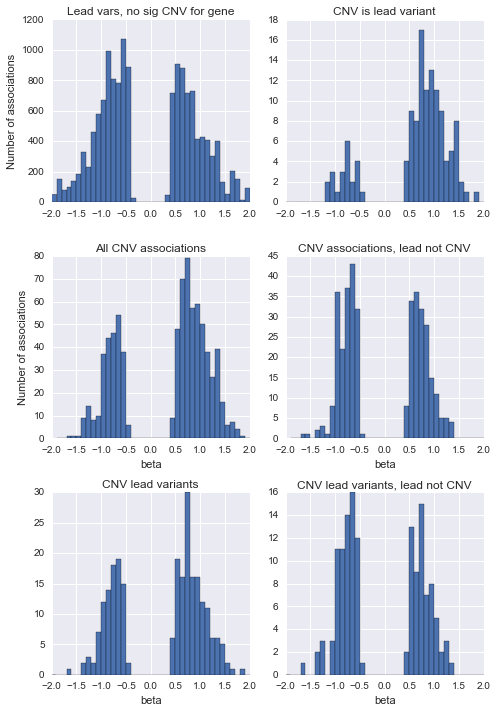

In [12]:
fig,axs = plt.subplots(3, 2, figsize=(7, 10))

# Lead variants, no sig CNV
ax = axs[0, 0]
lead_vars[lead_vars.cnv_sig == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_title('Lead vars, no sig CNV for gene')

# CNV is lead variant
ax = axs[0, 1]
# For lumpy deletions, having an alt alleles means lower copy number, so I need
# to reverse the beta values.
se = cnv_lead_vars.beta
ind = cnv_lead_vars[(cnv_lead_vars.variant_caller == 'lumpy') & 
                    (cnv_lead_vars.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_title('CNV is lead variant')

# All CNV associations
ax = axs[1, 0]
se = cnv_gv.beta
ind = cnv_gv[(cnv_gv.variant_caller == 'lumpy') & 
             (cnv_gv.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_xlabel('beta')
ax.set_title('All CNV associations')

# All CNV associations for genes where CNV is not the lead
ax = axs[1, 1]
se = cnv_gv.beta
ind = cnv_gv[(cnv_gv.variant_caller == 'lumpy') & 
             (cnv_gv.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se = se[cnv_gv.cnv_is_lead == False]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV associations, lead not CNV')
ax = axs[2, 0]
cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants')
ax = axs[2, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta.hist(
    ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants, lead not CNV')
plt.tight_layout()

In [13]:
cnv_lead_vars.sort_values(by='pvalue', inplace=True)
lead_vars.sort_values(by='pvalue', inplace=True)

p=0.00173688834161, Mann Whitney U


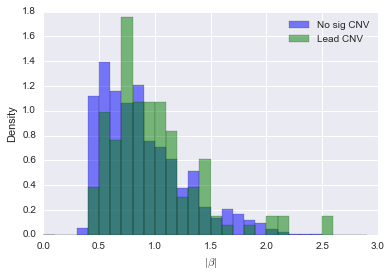

In [14]:
lead_vars[lead_vars.cnv_sig == False].beta.abs().hist(color='blue', alpha=0.5, 
                                                      normed=True, label='No sig CNV',
                                                      bins=np.arange(0, 3, 0.1))
cnv_lead_vars.beta.abs().hist(color='green', alpha=0.5, normed=True, label='Lead CNV',
                              bins=np.arange(0, 3, 0.1))
plt.xlabel('$|\\beta|$')
plt.ylabel('Density')
plt.legend();
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta.abs(),
                         cnv_lead_vars.beta.abs())
print('p={}, Mann Whitney U'.format(p))

In [15]:
cnv_abs_beta_pdf = pd.Series(index=np.arange(0, 3 + 0.05, 0.05))
density = stats.gaussian_kde(cnv_lead_vars.drop_duplicates('gene_id').beta.abs())
cnv_abs_beta_pdf = pd.Series(density(cnv_abs_beta_pdf.index), index=cnv_abs_beta_pdf.index)
snv_abs_beta_pdf = pd.DataFrame(index=np.arange(0, 3 + 0.005, 0.005))
density = stats.gaussian_kde(lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs())
snv_abs_beta_pdf = pd.Series(density(snv_abs_beta_pdf.index), index=snv_abs_beta_pdf.index)

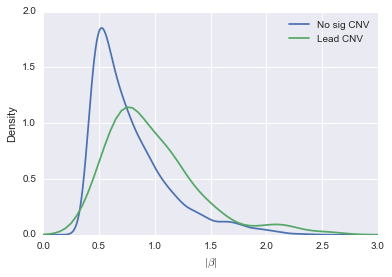

In [16]:
snv_abs_beta_pdf.plot(label='No sig CNV')
cnv_abs_beta_pdf.plot(label='Lead CNV')
plt.xlabel('$|\\beta|$')
plt.ylabel('Density')
plt.legend();

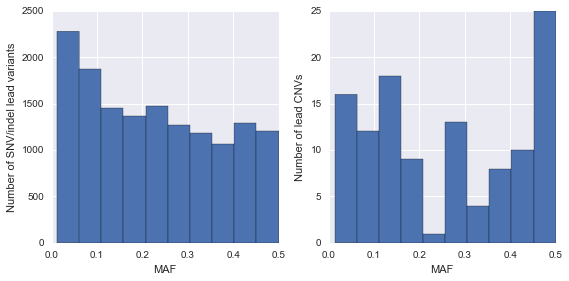

In [17]:
fig,axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
lead_vars[lead_vars.cnv_is_lead == False].drop_duplicates('location').maf.hist(ax=ax)
ax.set_xlabel('MAF')
ax.set_ylabel('Number of SNV/indel lead variants')
ax = axs[1]
cnv_lead_vars.drop_duplicates('location').maf.hist(ax=ax)
ax.set_xlabel('MAF')
ax.set_ylabel('Number of lead CNVs')
plt.tight_layout()

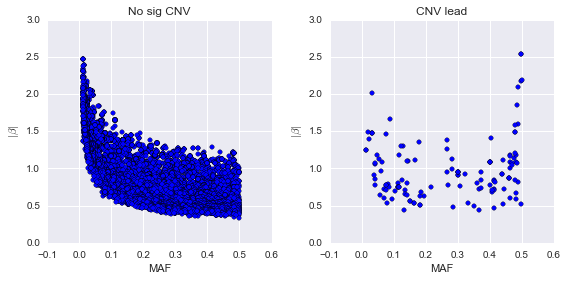

In [18]:
fig,axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
ax.scatter(lead_vars[lead_vars.cnv_sig == False].maf, 
           lead_vars[lead_vars.cnv_sig == False].beta.abs())
ax.set_xlabel('MAF')
ax.set_ylabel('$|\\beta|$')
ax.set_title('No sig CNV')
ax = axs[1]
ax.scatter(cnv_lead_vars.maf, cnv_lead_vars.beta.abs())
ax.set_xlabel('MAF')
ax.set_ylabel('$|\\beta|$')
ax.set_title('CNV lead')
plt.tight_layout()

In [19]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_lead_vars.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'lead CNVs for eGenes with lead CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'all sig. CNVs for eGenes with sig CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(cnv_gv[cnv_gv.cnv_is_lead == False].beta,
                         cnv_gv.beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)

Effect size for lead variants for eGenes with no lead CNV vs. lead CNVs for eGenes with lead CNV: p=2.89e-19
Effect size for lead variants for eGenes with no lead CNV vs. all sig. CNVs for eGenes with sig CNV: p=3.80e-33
1.11942740191e-14
3.29663797366e-07
0.460461277576


## Properties

In [20]:
s = '\n'.join(combined_info.chrom + '\t' + combined_info.start.astype(str) + 
              '\t' + combined_info.end.astype(str) + '\t' + combined_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

res = cnv_bt.intersect(gene_bt, sorted=True, wo=True)
df = res.to_dataframe()
overlaps_gene = set(df.name)

cnv_gv['cnv_gene'] = cnv_gv.cnv_id + ':' + cnv_gv.gene_id
t = pd.DataFrame(True, index=df.name + ':' + df.thickEnd, columns=['cnv_overlaps_gene'])
cnv_gv = cnv_gv.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_gv.ix[cnv_gv.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

In [21]:
sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(combined_info.index) - sig_cnvs

### Length

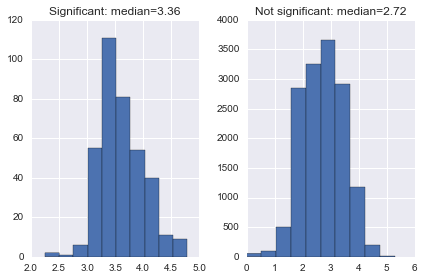

In [22]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(combined_info.ix[sig_cnvs, 'svlen']).abs().hist(ax=ax)
ax.set_title('Significant: median={:.2f}'.format(np.log10(combined_info.ix[sig_cnvs, 'svlen'].abs()).median()))
ax = axs[1]
np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs()).hist()
ax.set_title('Not significant: median={:.2f}'.format(np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs().median())));
plt.tight_layout()

In [23]:
s,p = stats.mannwhitneyu(combined_info.ix[sig_cnvs, 'svlen'].abs(), 
                         combined_info.ix[not_sig_cnvs, 'svlen'].abs())
print('CNVs with significant associations are longer than those without '
      'significant associations: p = {:.2e}'.format(p))
a = combined_info.ix[sig_cnvs, 'svlen'].abs().median()
b = combined_info.ix[not_sig_cnvs, 'svlen'].abs().median()
print('Sig median length = {}'.format(a))
print('Not sig median length = {}'.format(b))

CNVs with significant associations are longer than those without significant associations: p = 1.07e-75
Sig median length = 2312.5
Not sig median length = 527.0


### Distance to nearest TSS

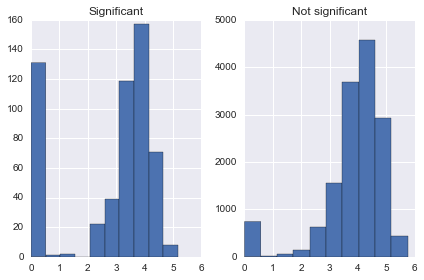

In [24]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist()
ax.set_title('Not significant');
plt.tight_layout()

We can see that significant CNVs are typically closer to a TSS than CNVs
that are not signficant.

In [25]:
a = combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
s,p = stats.mannwhitneyu(a, b)
print('CNVs with significant associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))
print('Median distance to nearest TSS for sig CNVs: {:,}'.format(a.median()))
print('Median distance to nearest TSS for not sig CNVs: {:,}'.format(b.median()))

CNVs with significant associations are closer to a TSS than those without significant associations: p = 9.91e-76
Median distance to nearest TSS for sig CNVs: 3,539.0
Median distance to nearest TSS for not sig CNVs: 12,391.0


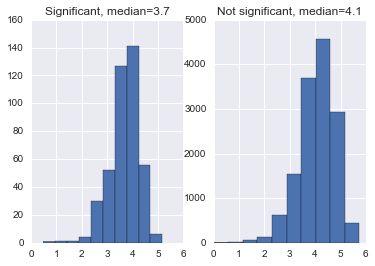

In [26]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
#a = combined_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [27]:
#a = combined_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print('Median distance to nearest TSS for sig CNVs: {:,}'.format(a.median()))
print('Median distance to nearest TSS for not sig CNVs: {:,}'.format(b.median()))
print('Removing all CNVs that overlap any gene, CNVs with significant '
      'associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))

Median distance to nearest TSS for sig CNVs: 5,451.0
Median distance to nearest TSS for not sig CNVs: 13,700.5
Removing all CNVs that overlap any gene, CNVs with significant associations are closer to a TSS than those without significant associations: p = 6.71e-40


Even if we remove CNVs that overlap genes, the significant
CNVs are still closer to genes.

### Gene overlap

In [28]:
overlaps_sig = len(sig_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=5.6e-17


## Intergenic CNV eQTLs

I'm going to look at CNV-eQTLs where the CNV doesn't overlap the affected gene.
This doesn't mean they are necessarily intergenic because they could overlap another gene,
but they don't overlap the gene they are associated with. 

I used the raw CNV calls for finding eQTLs, but I'll switch here to use the combined CNVs 
so I can be conservative in defining whether the CNV overlaps the gene.

In [29]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'combined_mapping.tsv')
mapping = pd.read_table(fn, index_col=0, header=None, squeeze=True)

For each gene, I'll define whether the gene overlaps a significant CNV. First,
I'll just look at the CNVs as they are defined by Genome Strip. Then I'll 
include my merged CNVs. Finally, I'll merge all CNVs that are associated with the
gene and see whether the gene falls in this region.

In [30]:
overlaps = set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'gene_id'])
t = cnv_gv[cnv_gv.gene_id.apply(lambda x: x not in overlaps)]
t = t[t.cnv_id.apply(lambda x: x in set(t.cnv_id) & set(mapping.index))]
t['combined'] = mapping[t.cnv_id].values
t = t.merge(gs_combined_info, left_on='combined', right_index=True, suffixes=['', '_combined'])
t = t.dropna(subset=['overlaps_gene'])
t = t[t.apply(lambda x: x['gene_id'] in x['overlaps_gene'], axis=1)]
overlaps |= set(t.gene_id)
t = cnv_gv[cnv_gv.gene_id.apply(lambda x: x not in overlaps)]
for gene in set(t.gene_id):
    tdf = t[t.gene_id == gene]
    start = tdf.start.min()
    end = tdf.end.max()
    if not (gene_info.ix[gene, 'start'] > end or gene_info.ix[gene, 'end'] < start):
        overlaps.add(gene)
overlaps = pd.Series(True, index=overlaps)
overlaps = pd.concat([pd.Series(False, index=list(set(cnv_gv.gene_id) - set(overlaps.index))), overlaps])
print('{} of {} genes with significant CNV eQTLs overlap the CNV.'.format(overlaps.sum(), overlaps.shape[0]))
print('{} of {} genes with significant CNV eQTLs don\'t overlap the CNV.'.format(
        sum(overlaps == False), overlaps.shape[0]))

99 of 247 genes with significant CNV eQTLs overlap the CNV.
148 of 247 genes with significant CNV eQTLs don't overlap the CNV.


In [31]:
102. / 247

0.41295546558704455

In [32]:
cnv_gv['cnv_overlaps_gene_cons'] = False
cnv_gv.ix[cnv_gv.gene_id.apply(lambda x: x in overlaps[overlaps].index), 'cnv_overlaps_gene_cons'] = True

In [33]:
a = len(set(cnv_gv[(cnv_gv.cnv_is_lead) & (cnv_gv.cnv_overlaps_gene_cons)].gene_id))
b = len(set(cnv_gv[cnv_gv.cnv_is_lead].gene_id))
print('{} of {} eGenes with CNV lead variant overlap a significant CNV.'.format(a, b))

59 of 108 eGenes with CNV lead variant overlap a significant CNV.


In [34]:
cnv_gv.to_pickle(os.path.join(outdir, 'cnv_gene_variants.pickle'))
combined_info.to_pickle(os.path.join(outdir, 'combined_info.pickle'))
lead_vars.to_pickle(os.path.join(outdir, 'lead_variants.pickle'))

I'll get one significant CNV per gene with a significant CNV association.

In [35]:
cnv_gv.sort_values(by=['gene_id', 'pvalue'], inplace=True)

In [36]:
sig_genic = set(cnv_gv[cnv_gv.cnv_overlaps_gene_cons].drop_duplicates(subset=['gene_id']).cnv_id)
sig_not_genic = set(cnv_gv[cnv_gv.cnv_overlaps_gene_cons == False].drop_duplicates(subset=['gene_id']).cnv_id)
not_sig = set(combined_info.index) - set(cnv_gv.cnv_id)

In [37]:
len(sig_genic & sig_not_genic)

16

There is some overlap between `sig_genic` and `sig_not_genic` because some particular CNVs
are eQTLs for multiple genes and overlap some of those genes but not others.

In [38]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

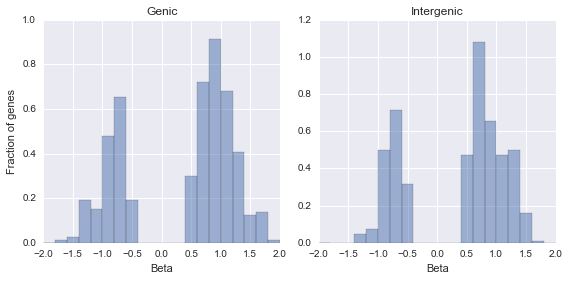

In [39]:
fig,axs = plt.subplots(1, 2, figsize=(8, 4))
tdf = cnv_gv.sort_values(by=['cnv_overlaps_gene', 'pvalue'], 
                         ascending=[False, True]).drop_duplicates(subset=['gene_id'])
a = cnv_gv[cnv_gv.cnv_overlaps_gene_cons]
b = cnv_gv[cnv_gv.cnv_overlaps_gene_cons == False]
ax = axs[0]
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('Beta')
ax.set_title('Genic')
a.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='genic', ax=ax)
ax = axs[1]
b.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='intergenic', ax=ax)
ax.set_title('Intergenic')
ax.set_xlabel('Beta')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'genic_vs_intergenic_beta.pdf'))

While these CNVs don't overlap the gene that they are an eQTL for, they are still
enriched for overlapping some other gene.

In [40]:
roadmap_overlap = pd.concat([gs_roadmap_overlap, lumpy_roadmap_overlap])
roadmap_overlap = roadmap_overlap.ix[combined_info.index]

In [41]:
cnv_gv.to_pickle(os.path.join(outdir, 'cnv_gene_variants.pickle'))

### Functional annotation enrichment

#### Sig. genic vs. not sig.

First I'll compare significant genic CNVs to CNVs that weren't significant.

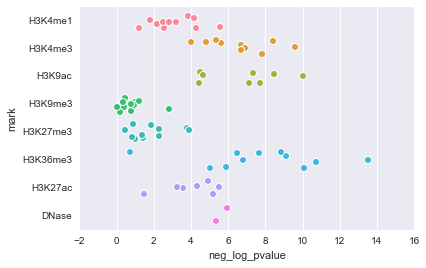

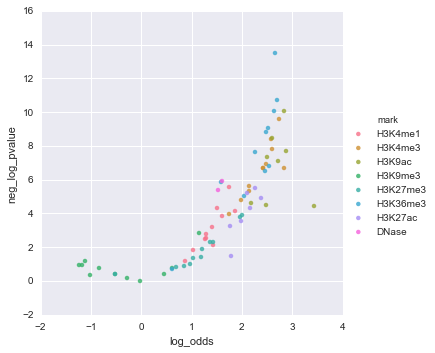

In [68]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_genic, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind
roadmap_res['log_odds'] = np.log2(roadmap_res.odds)
roadmap_res['neg_log_pvalue'] = -np.log10(roadmap_res.pvalue)

roadmap_res.to_csv(os.path.join(outdir, 'sig_genic_vs_not_sig_roadmap_res.tsv'), sep='\t')

sns.stripplot(y='mark', x='neg_log_pvalue', data=roadmap_res, jitter=0.3, orient='h');
sns.lmplot(x='log_odds', y='neg_log_pvalue', data=roadmap_res, hue='mark', fit_reg=False);

We can see enrichment for various active regulatory marks, particularly H3K36me3
which is associated with the transcribed parts of genes.

#### Sig. not genic vs. genic sig.

Now let's compare significant genic versus significant not genic CNVs.

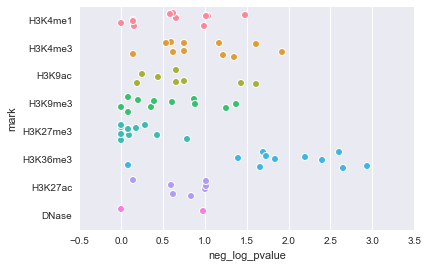

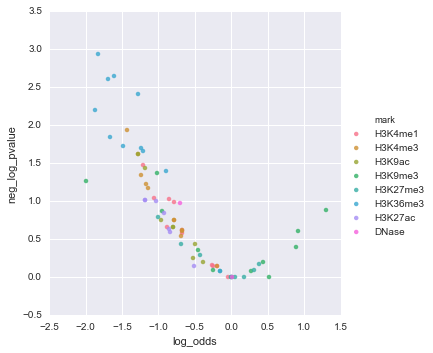

In [70]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_not_genic, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[sig_genic, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind
roadmap_res['log_odds'] = np.log2(roadmap_res.odds)
roadmap_res['neg_log_pvalue'] = -np.log10(roadmap_res.pvalue)

roadmap_res.to_csv(os.path.join(outdir, 'sig_not_genic_vs_sig_genic_roadmap_res.tsv'), sep='\t')

sns.stripplot(y='mark', x='neg_log_pvalue', data=roadmap_res, jitter=0.3, orient='h');
sns.lmplot(x='log_odds', y='neg_log_pvalue', data=roadmap_res, hue='mark', fit_reg=False);

We can see that the genic CNVs are enriched for H3K36me3 relative to the not
genic CNVs. So the not genic CNVs are noticeably different.

#### Sig. not genic vs. not sig.

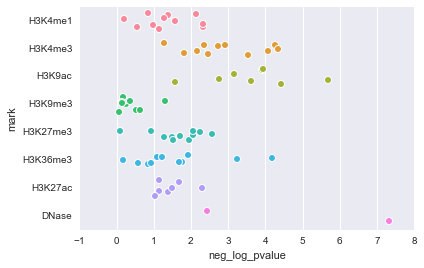

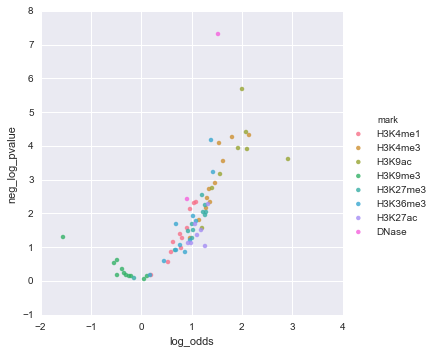

In [71]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_not_genic, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind
roadmap_res['log_odds'] = np.log2(roadmap_res.odds)
roadmap_res['neg_log_pvalue'] = -np.log10(roadmap_res.pvalue)

roadmap_res.to_csv(os.path.join(outdir, 'sig_not_genic_vs_not_sig_roadmap_res.tsv'), sep='\t')

sns.stripplot(y='mark', x='neg_log_pvalue', data=roadmap_res, jitter=0.3, orient='h');
sns.lmplot(x='log_odds', y='neg_log_pvalue', data=roadmap_res, hue='mark', fit_reg=False);

We see enrichment for various active regulatory marks. So these CNVs are 
hitting regulatory regions.

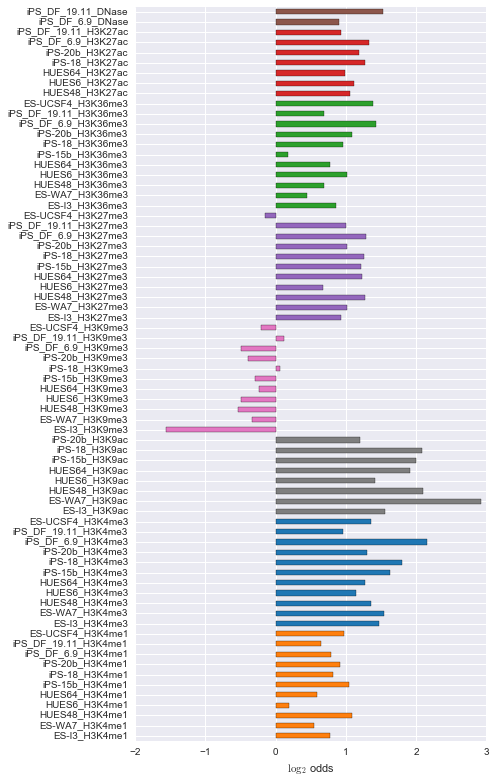

In [72]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()
plt.xlabel('$\log_2$ odds')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'intergenic_histone_mark_odds.pdf'))

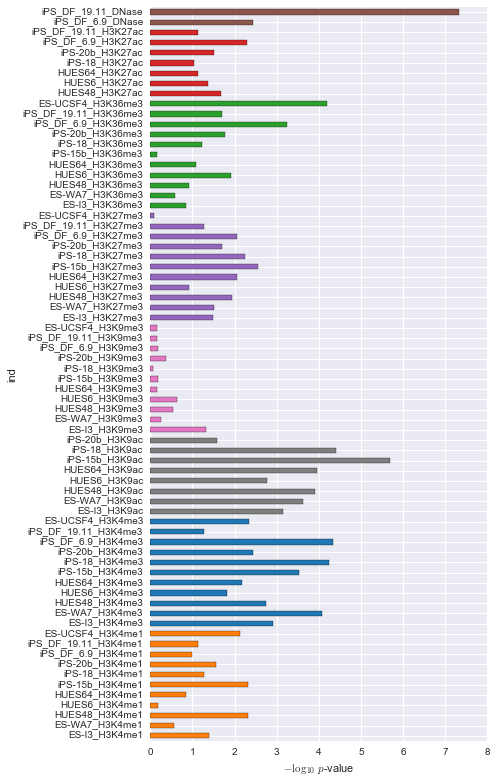

In [73]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()